In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from regression import PCovR, KPCovR, SparseKPCovR
from regression import LR, KRR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast
from soap import extract_species_pair_groups
from errors import MAE

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression

# Utilities
import h5py
import json
import itertools
from copy import deepcopy
from tqdm.notebook import tqdm
import project_utils as utils
from tools import load_json, save_json, save_structured_array

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


In [3]:
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/analysis/scripts')
# from utilities.sklearn_covr.kpcovr import KernelPCovR as KPCovR2
# from utilities.sklearn_covr.pcovr import PCovR as PCovR2
from helpers import l_regr, l_kpcovr, l_proj

# Functions

In [4]:
def compute_regression_losses(y_train, y_test, yp_train, yp_test):
    
    # Sum over cantonwise losses
    lr_test = np.sum(l_regr(y_test, yp_test))
    lr_train = np.sum(l_regr(y_train, yp_train))

    return lr_train, lr_test

def compute_kernel_projection_losses(k_train, k_test, k_test_test, t_train, t_test):
    
    # Sum over cantonwise losses
    lp_test = np.sum(l_kpcovr(k_train=k_train,
                              k_test=k_test,
                              k_test_test=k_test_test,
                              t_train=t_train, t_test=t_test))

    lp_train = np.sum(l_kpcovr(k_train=k_train,
                               t_train=t_train, t_test=t_test))

    return lp_train, lp_test

def compute_linear_projection_losses(x_train, x_test, xr_train, xr_test):
    
    # Sum over cantonwise losses
    lp_train = np.sum(l_proj(x_train, xr=xr_train))
    lp_test = np.sum(l_proj(x_test, xr=xr_test))

    return lp_train, lp_test

def load_pcovr_losses(filename, alphas, regularizations, dtype):
    
    # Load losses
    loss_matrix_shape = (len(alphas), len(regularizations))
    pcovr_errors = np.loadtxt(filename, dtype=dtype)
    alpha_matrix = np.reshape(pcovr_errors['alpha'], loss_matrix_shape)
    reg_matrix = np.reshape(pcovr_errors['regularization'], loss_matrix_shape)
    lr_train_matrix = np.reshape(np.mean(pcovr_errors['lr_train'], axis=1), loss_matrix_shape)
    lr_test_matrix = np.reshape(np.mean(pcovr_errors['lr_test'], axis=1), loss_matrix_shape)
    lp_train_matrix = np.reshape(np.mean(pcovr_errors['lp_train'], axis=1), loss_matrix_shape)
    lp_test_matrix = np.reshape(np.mean(pcovr_errors['lp_test'], axis=1), loss_matrix_shape)
    alphas = alpha_matrix[:, 0]
    opt_reg_idx = np.unravel_index(np.argmin(lr_test_matrix + lp_test_matrix), 
                                   lr_test_matrix.shape)[1]
    
    return alphas, opt_reg_idx, \
        lr_train_matrix, lr_test_matrix, lp_train_matrix, lp_test_matrix

# Load train and test splits

In [5]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [6]:
# Load train and test set indices for Deem
idxs_deem = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)

# Total number of structures
n_deem = idxs_deem.size + np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int).size

In [7]:
idxs_deem_train_file = '../Processed_Data/Models/deem_train_ksvc-kpcovr.idxs'
idxs_deem_test_file = '../Processed_Data/Models/deem_test_ksvc-kpcovr.idxs'

# Load indices for kernel building
try:
    idxs_deem_train = np.loadtxt(idxs_deem_train_file, dtype=int)
    idxs_deem_test = np.loadtxt(idxs_deem_test_file, dtype=int)
    n_deem_train = len(idxs_deem_train)
    n_deem_test = len(idxs_deem_test)
    
    # Check to make sure the test and train set sizes are correct
    print(n_deem_train, n_deem_test)

# Compute indices if they don't exist
except IOError:

    n_deem_train = 5000
    n_deem_test = 2750
    
    # Deem is already shuffled, don't need to do so here
    idxs_deem_train = idxs_deem[0:n_deem_train]
    idxs_deem_test = idxs_deem[n_deem_train:n_deem_train+n_deem_test]
    
    np.savetxt(idxs_deem_train_file, idxs_deem_train, fmt='%d')
    np.savetxt(idxs_deem_test_file, idxs_deem_test, fmt='%d')

5000 2750


In [8]:
# Make DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

In [9]:
# Load IZA cantons
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]

cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [10]:
idxs_iza_train_file = '../Processed_Data/Models/iza_train_ksvc-kpcovr.idxs'
idxs_iza_test_file = '../Processed_Data/Models/iza_test_ksvc-kpcovr.idxs'

# Load indices for kernel building
try:
    idxs_iza_train = np.loadtxt(idxs_iza_train_file, dtype=int)
    idxs_iza_test = np.loadtxt(idxs_iza_test_file, dtype=int)
    
    # Check to make sure the test and train set sizes are correct
    print(len(idxs_iza_train), len(idxs_iza_test))

# Compute indices if they don't exist
except IOError:

    idxs_iza_train = np.arange(0, n_iza)
    idxs_iza_test = np.arange(0, n_iza)
    
    np.savetxt(idxs_iza_train_file, idxs_iza_train, fmt='%d')
    np.savetxt(idxs_iza_test_file, idxs_iza_test, fmt='%d')

225 225


In [11]:
# Build set of "master" canton labels
cantons_train = {}
cantons_test = {}

cantons_train[4] = np.concatenate((cantons_iza[idxs_iza_train], cantons_deem[idxs_deem_train]))
cantons_test[4] = np.concatenate((cantons_iza[idxs_iza_test], cantons_deem[idxs_deem_test]))

cantons_train[2] = np.concatenate((np.ones(len(idxs_iza_train), dtype=int),
                                   np.ones(len(idxs_deem_train), dtype=int) * 2))
cantons_test[2] = np.concatenate((np.ones(len(idxs_iza_test), dtype=int),
                                  np.ones(len(idxs_deem_test), dtype=int) * 2))

## Optimization

In [12]:
n_subsets = 5

In [13]:
idxs_iza_train_kernel_file = '../Processed_Data/Models/iza_train_ksvc-kpcovr_optimization.idxs'
idxs_iza_test_kernel_file = '../Processed_Data/Models/iza_test_ksvc-kpcovr_optimization.idxs'

# Load IZA array splits for optimization
try:
    idxs_iza_train_kernel = [np.asarray(i) for i in load_json(idxs_iza_train_kernel_file)]
    idxs_iza_test_kernel = [np.asarray(i) for i in load_json(idxs_iza_test_kernel_file)]
    
    # Check to make sure the train and test sizes are correct
    print([len(i) for i in idxs_iza_train_kernel], [len(i) for i in idxs_iza_test_kernel])
    
# Compute indices if they don't exist
except IOError:
    
    idxs_iza = np.arange(0, n_iza)
    n_iza_train_kernel = int(n_iza / 2)
    n_iza_test_kernel = n_iza - n_iza_train_kernel

    idxs_iza_train_kernel = []
    idxs_iza_test_kernel = []
    for n in range(0, n_subsets):
        np.random.shuffle(idxs_iza)
        
        # Need to append copies, otherwise the previously appended objects
        # are updated with the new shuffled indices at each iteration
        idxs_iza_train_kernel.append(idxs_iza[0:n_iza_train_kernel].copy())
        idxs_iza_test_kernel.append(idxs_iza[n_iza_train_kernel:].copy())
    
    save_json(idxs_iza_train_kernel, idxs_iza_train_kernel_file, array_convert=True)
    save_json(idxs_iza_test_kernel, idxs_iza_test_kernel_file, array_convert=True)

[112, 112, 112, 112, 112] [113, 113, 113, 113, 113]


In [14]:
idxs_deem_train_kernel_file = '../Processed_Data/Models/deem_train_ksvc-kpcovr_optimization.idxs'
idxs_deem_test_kernel_file = '../Processed_Data/Models/deem_test_ksvc-kpcovr_optimization.idxs'

# Load DEEM array splits for optimization
try:
    idxs_deem_train_kernel = [np.asarray(i) for i in load_json(idxs_deem_train_kernel_file)]
    idxs_deem_test_kernel = [np.asarray(i) for i in load_json(idxs_deem_test_kernel_file)]
    
    # Check to make sure the train and test sizes are correct
    print([len(i) for i in idxs_deem_train_kernel], [len(i) for i in idxs_deem_test_kernel])

# Compute indices if they don't exist
except IOError:

    idxs_deem_train_kernel = np.arange(idxs_iza_train.size, idxs_iza_train.size+idxs_deem_train.size)
    np.random.shuffle(idxs_deem_train_kernel)
    idxs_deem_train_kernel = np.split(idxs_deem_train_kernel, n_subsets)

    idxs_deem_test_kernel = np.arange(idxs_iza_test.size, idxs_iza_test.size+idxs_deem_test.size)
    np.random.shuffle(idxs_deem_test_kernel)
    idxs_deem_test_kernel = np.split(idxs_deem_test_kernel, n_subsets)
    
    save_json(idxs_deem_train_kernel, idxs_deem_train_kernel_file, array_convert=True)
    save_json(idxs_deem_test_kernel, idxs_deem_test_kernel_file, array_convert=True)

[1000, 1000, 1000, 1000, 1000] [550, 550, 550, 550, 550]


In [15]:
# Concatenate the DEEM and IZA indices
idxs_train_kernel = [np.concatenate((iza, deem)) for iza, deem in 
                     zip(idxs_iza_train_kernel, idxs_deem_train_kernel)]
idxs_test_kernel = [np.concatenate((iza, deem)) for iza, deem in
                    zip(idxs_iza_test_kernel, idxs_deem_test_kernel)]

In [16]:
# Initialize datatype for saving KSVC classification accuracies and KPCovR losses
dt_pcovr_list = [('alpha', 'f8'),
                 ('regularization', 'f8'),
                 ('lr_train', 'f8', (n_subsets,)),
                 ('lr_test', 'f8', (n_subsets)),
                 ('lp_train', 'f8', (n_subsets,)),
                 ('lp_test', 'f8', (n_subsets))]

dt_svm_list = [('C', 'f8'),
               ('class_accuracy_train', 'f8', (n_subsets,)),
               ('class_accuracy_test', 'f8', (n_subsets,))]

save_json(dt_pcovr_list, '../Processed_Data/Models/covr_optimization_dtype.json')
save_json(dt_svm_list, '../Processed_Data/Models/svm_optimization_dtype.json')

dt_pcovr = np.dtype(dt_pcovr_list)
dt_svm = np.dtype(dt_svm_list)

## Model evaluation

In [17]:
idxs_deem_train_all_file = '../Processed_Data/Models/deem_train_ksvc-kpcovr_evaluation.idxs'
idxs_deem_test_all_file = '../Processed_Data/Models/deem_test_ksvc-kpcovr_evaluation.idxs'

# Load DEEM indices for running the models on the full optimization set
try:
    idxs_deem_train_all = np.loadtxt(idxs_deem_train_all_file, dtype=int)
    idxs_deem_test_all = np.loadtxt(idxs_deem_test_all_file, dtype=int)
    
    # Check to make sure the test and train set sizes are correct
    print(len(idxs_deem_train_all), len(idxs_deem_test_all))
    
# Compute indices if they don't exist
except IOError:

    idxs_deem_train_all = np.concatenate(idxs_deem_train_kernel)
    idxs_deem_test_all = np.concatenate(idxs_deem_test_kernel)
    
    np.savetxt(idxs_deem_train_all_file, idxs_deem_train_all, fmt='%d')
    np.savetxt(idxs_deem_test_all_file, idxs_deem_test_all, fmt='%d')

5000 2750


In [18]:
idxs_iza_train_all_file = '../Processed_Data/Models/iza_train_ksvc-kpcovr_evaluation.idxs'
idxs_iza_test_all_file = '../Processed_Data/Models/iza_test_ksvc-kpcovr_evaluation.idxs'

# Load IZA indices for running the models on the full optimization set
try:
    idxs_iza_train_all = np.loadtxt(idxs_iza_train_all_file, dtype=int)
    idxs_iza_test_all = np.loadtxt(idxs_iza_test_all_file, dtype=int)
    
    n_iza_train = len(idxs_iza_train_all)
    n_iza_test = len(idxs_iza_test_all)
    
    # Check to make sure the test and train set sizes are correct
    print(len(idxs_iza_train_all), len(idxs_iza_test_all))

# Compute indices if they don't exist
except IOError:

    idxs_iza = np.arange(0, n_iza)
    n_iza_train = n_iza // 2
    n_iza_test = n_iza - n_iza_train

    np.random.shuffle(idxs_iza)
    idxs_iza_train_all = idxs_iza[0:n_iza_train]
    idxs_iza_test_all = idxs_iza[n_iza_train:]
    
    np.savetxt(idxs_iza_train_all_file, idxs_iza_train_all, fmt='%d')
    np.savetxt(idxs_iza_test_all_file, idxs_iza_test_all, fmt='%d')

112 113


In [19]:
# Concatenate the DEEM and IZA indices
idxs_train_all = np.concatenate((idxs_iza_train_all, idxs_deem_train_all))
idxs_test_all = np.concatenate((idxs_iza_test_all, idxs_deem_test_all))

# Model setup

In [20]:
model_dir = '../Processed_Data/Models'

deem_name = 'DEEM_10k'
iza_name = 'IZA_226onDEEM_10k'
deem_dir = f'../Processed_Data/{deem_name}/Data'
iza_dir = f'../Processed_Data/{iza_name}/Data'

In [21]:
# TODO: parameter optimization handling with defaults dictated here

In [22]:
# Global model parameters
# TODO: or use .get_params()?
# TODO: should we make sure break_ties=True?
# TODO: swap dual in linear if features > samples?
svc_kwargs = dict(linear=dict(penalty='l2',
                              loss='squared_hinge',
                              dual=False,
                              multi_class='ovr',
                              class_weight=None,
                              fit_intercept=True,
                              intercept_scaling=1.0,
                              tol=1.0E-3,
                              max_iter=1000,
                              C=1.0),
                  kernel=dict(kernel='precomputed',
                              decision_function_shape='ovr',
                              class_weight=None,
                              break_ties=False,
                              tol=1.0E-3,
                              max_iter=1000,
                              C=1.0))

n_components = 2
pcovr_kwargs = dict(linear=dict(n_components=n_components, alpha=0.0, regularization=1.0E-12),
                    kernel=dict(n_components=n_components, alpha=0.0, regularization=1.0E-12))

# C = np.logspace(-5, 5, 11)
# alphas = np.linspace(0.0, 1.0, 11)
# regularizations = np.logspace(-12, -1, 12)

C = np.logspace(-5, 5, 2)
alphas = np.linspace(0.0, 1.0, 2)
regularizations = np.logspace(-12, -1, 2)

In [23]:
# Index slices for saving KSVC and KPCovR outputs
deem_train_slice = slice(n_iza_train, None)
deem_test_slice = slice(n_iza_test, None)
iza_train_slice = slice(0, n_iza_train)
iza_test_slice = slice(0, n_iza_test)

# Build kernels

In [24]:
# Load the kernels or compute if they don't exist
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        
        work_dir = f'{model_dir}/{cutoff}/Kernel_Models/{kernel_name}/KSVC-KPCovR'
        
        if not os.path.exists(work_dir):
            os.makedirs(work_dir)
        
        # File to store kernels for re-use
        kernel_file = f'{work_dir}/structure_kernels_optimization.hdf5'
        kernel_parameter_file = f'{work_dir}/volumes_mae_parameters.json'

        if not os.path.exists(kernel_file):
            
            # SOAP files (atomwise, FPS'ed features)
            deem_file = f'{deem_dir}/{cutoff}/soaps.hdf5'
            iza_file = f'{iza_dir}/{cutoff}/soaps.hdf5'

            # Assemble the train and test set SOAPs from IZA and DEEM
            soaps_train, soaps_test = utils.load_soaps(deem_file, iza_file,
                                                       idxs_deem_train, idxs_deem_test,
                                                       idxs_iza_train, idxs_iza_test,
                                                       idxs_iza_delete=[RWY])

            # Compute kernels
            # TODO: this can be consolidated if doing linear KRR
            if kernel_type == 'gaussian':
                kernel_parameters = load_json(kernel_parameter_file)
                kernel_parameters.pop('sigma')
                kernel_parameters.pop('regularization')
            else:
                kernel_parameters = dict(kernel='linear', zeta=1)
            utils.compute_kernels(soaps_train, soaps_test, kernel_file=kernel_file, **kernel_parameters)

# Kernel Models

## Optimize KernelSVC parameters

In [25]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    
    for kernel_type in tqdm(('linear', 'gaussian'), desc='Kernel', leave=False):
        kernel_name = kernel_type.capitalize()
        
        work_dir = f'{model_dir}/{cutoff}/Kernel_Models/{kernel_name}/KSVC-KPCovR'
        
        # Load kernels
        kernel_file = f'{work_dir}/structure_kernels_optimization.hdf5'
        K_train, K_test, K_test_test = utils.load_kernels(kernel_file)
        
        for n_cantons in tqdm((2, 4), desc='Classes', leave=False):
            
            # Output setup
            output_dir = f'{n_cantons}-Class'
            
            if not os.path.exists(f'{work_dir}/{output_dir}'):
                os.makedirs(f'{work_dir}/{output_dir}')
            
            svc_parameter_file = f'{work_dir}/{output_dir}/svc_parameters.json'
            svc_parameters = svc_kwargs['kernel'].copy()
            
            svc_errors = []
            
            for cdx, c in enumerate(tqdm(C, desc='C', leave=False)):
                
                svc_parameters.update(C=c)
                class_accuracy_train = np.zeros(n_subsets)
                class_accuracy_test = np.zeros(n_subsets)
                
                for n in tqdm(range(0, n_subsets), desc='n', leave=False):
                    
                    # Slice kernels
                    idxs_train = idxs_train_kernel[n]
                    idxs_test = idxs_test_kernel[n]
                    
                    k_train = K_train[idxs_train, :][:, idxs_train]
                    k_test = K_test[idxs_test, :][:, idxs_train]
                    k_test_test = K_test_test[idxs_test, :][:, idxs_test]
                    
                    # Center and scale kernels
                    k_train, k_test, k_test_test = \
                        utils.preprocess_kernels(k_train, K_test=k_test, 
                                                 K_test_test=k_test_test, K_bridge=k_test)
                    
                    y_train = cantons_train[n_cantons][idxs_train]
                    y_test = cantons_test[n_cantons][idxs_test]
                    
                    # Run KSVC
                    yp_train, yp_test = \
                        utils.do_svc(k_train, k_test, y_train, y_test, 
                                     svc_type='kernel', **svc_parameters, outputs=['predictions'])
                    
                    class_accuracy_train[n] = accuracy_score(y_train, yp_train)
                    class_accuracy_test[n] = accuracy_score(y_test, yp_test)
                    
                    # Collect errors
                    model = np.array([(c, class_accuracy_train, class_accuracy_test)], dtype=dt_svm)
                    svc_errors.append(model)
            
            svc_errors = np.concatenate(svc_errors)
            
            # Stack the arrays in a writable form so we can save in plain text instead of npy/npz
            save_structured_array(f'{work_dir}/{output_dir}/svm_optimization.dat',
                                  svc_errors, dt_svm)
            
            # TODO: use accuracy only on IZA structures?
            class_accuracy_train_avg = np.mean(svc_errors['class_accuracy_train'], axis=1)
            class_accuracy_test_avg = np.mean(svc_errors['class_accuracy_test'], axis=1)
            
            # Save KSVC parameters
            idx_C = np.argmax(class_accuracy_test_avg)
            C_opt = svc_errors['C'][idx_C]
            svc_parameters.update(C=C_opt)
            save_json(svc_parameters, svc_parameter_file)

## Optimal KernelSVC

In [26]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    
    for kernel_type in tqdm(('linear', 'gaussian'), desc='Kernel', leave=False):
        kernel_name = kernel_type.capitalize()
        
        work_dir = f'{model_dir}/{cutoff}/Kernel_Models/{kernel_name}/KSVC-KPCovR'
        
        # Load kernels
        kernel_file = f'{work_dir}/structure_kernels_optimization.hdf5'
        K_train, K_test, K_test_test = utils.load_kernels(kernel_file)
        
        # Since we need decision functions for all IZA structures in the train set,
        # predict all structures
        k_train_all = K_train[:, idxs_train_all]
        k_test_all = K_test[:, idxs_train_all]

        k_train = k_train_all[idxs_train_all, :]
        k_test = k_test_all[idxs_test_all, :]
        
        k_train, [k_test, k_train_all, k_test_all] = \
            utils.preprocess_kernels(k_train, K_test=[k_test, k_train_all, k_test_all])
        
        for n_cantons in tqdm((2, 4), desc='Classes', leave=False):
            
            # Output setup
            output_dir = f'{n_cantons}-Class'
            svc_parameter_file = f'{work_dir}/{output_dir}/svc_parameters.json'
            svc_df_train_file = f'{work_dir}/{output_dir}/svc_structure_dfs_train_optimization.dat'
            svc_df_test_file = f'{work_dir}/{output_dir}/svc_structure_dfs_test_optimization.dat'
                    
            # Assemble properties
            y_train = cantons_train[n_cantons][idxs_train_all]
            y_test = cantons_test[n_cantons][idxs_test_all]
            
            # KSVC
            svc_parameters = load_json(svc_parameter_file)
            df_train, [df_test, df_train_all, df_test_all] = \
                utils.do_svc(k_train, [k_test, k_train_all, k_test_all], 
                             y_train, y_test, svc_type='kernel',
                             **svc_parameters, outputs=['decision_functions'])
            
            # Save decision functions for KRR test and KPCovR optimization
            np.savetxt(svc_df_train_file, df_train_all)
            np.savetxt(svc_df_test_file, df_test_all)

## KRR check

In [28]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    
    for kernel_type in tqdm(('linear', 'gaussian'), desc='Kernel', leave=False):
        kernel_name = kernel_type.capitalize()
        
        work_dir = f'{model_dir}/{cutoff}/Kernel_Models/{kernel_name}/KSVC-KPCovR'
        
        # Load kernels
        kernel_file = f'{work_dir}/structure_kernels_optimization.hdf5'
        K_train, K_test, K_test_test = utils.load_kernels(kernel_file)

        # Slice kernels
        k_train = K_train[idxs_train_all, :][:, idxs_train_all]
        k_test = K_test[idxs_test_all, :][:, idxs_train_all]

        k_train, [k_test, k_train_all, k_test_all] = \
            utils.preprocess_kernels(k_train, K_test=[k_test, k_train_all, k_test_all])
        
        for n_cantons in tqdm((2, 4), desc='Classes', leave=False):
            
            # Load decision functions
            input_dir = f'{n_cantons}-Class'
            svc_df_train_file = f'{work_dir}/{input_dir}/svc_structure_dfs_train_optimization.dat'
            svc_df_test_file = f'{work_dir}/{input_dir}/svc_structure_dfs_test_optimization.dat'
            
            df_train = np.loadtxt(svc_df_train_file)[idxs_train_all]
            df_test = np.loadtxt(svc_df_test_file)[idxs_test_all]
            
            # Center and scale the decision functions
            df_train, df_test, df_center, df_scale = \
                utils.preprocess_data(df_train, df_test)

            # Check that KRR can reproduce the decision functions
            dfp_train, dfp_test = \
                utils.regression_check(k_train, k_test, df_train, df_test, 
                                       regression_type='kernel')
            
            print(MAE(dfp_train, df_train))
            print(MAE(dfp_test, df_test))

0.4012896251848945
0.5302715018364427
[0.180979   0.21552652 0.21594962 0.13751533]
[0.23221891 0.27119854 0.26775783 0.21298564]


0.0027934266024773028
4.655499575055883
[2.09292528e-03 7.78923464e-06 5.32589901e-04 7.19140828e-04]
[3.66268874 0.32366571 1.01734868 1.5106835 ]


0.3552491120556414
0.4031467887486718
[0.21262882 0.22785307 0.23667825 0.13060507]
[0.24695648 0.24965485 0.25912066 0.15411491]


3.208748425025548e-11
0.28655279963936614
[1.91909497e-11 2.62604662e-11 2.19932365e-11 3.76952869e-12]
[0.25100436 0.25844607 0.25439527 0.04394289]



In [ ]:
# TODO: check if ovo decision functions can be predicted any better

## Optimize KPCovR parameters

In [40]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    
    for kernel_type in tqdm(('linear', 'gaussian'), desc='Kernel', leave=False):
        kernel_name = kernel_type.capitalize()
        
        work_dir = f'{model_dir}/{cutoff}/Kernel_Models/{kernel_name}/KSVC-KPCovR'
        
        # Load kernels
        kernel_file = f'{work_dir}/structure_kernels_optimization.hdf5'
        K_train, K_test, K_test_test = utils.load_kernels(kernel_file)
        
        for n_cantons in tqdm((2, 4), desc='Classes', leave=False):
            
            # Prepare inputs and outputs
            output_dir = f'{n_cantons}-Class' 
            pcovr_parameter_file = f'{work_dir}/{output_dir}/pcovr_parameters.json'
            svc_parameter_file = f'{work_dir}/{output_dir}/svc_parameters.json'
            
            svc_parameters = load_json(svc_parameter_file)
            pcovr_parameters = pcovr_kwargs['kernel'].copy()

            # Load decision functions
            svc_df_train_file = f'{work_dir}/{output_dir}/svc_structure_dfs_train_optimization.dat'
            svc_df_test_file = f'{work_dir}/{output_dir}/svc_structure_dfs_test_optimization.dat'
            
            df_train = np.loadtxt(svc_df_train_file)
            df_test = np.loadtxt(svc_df_test_file)
            
            pcovr_errors = []
                        
            for adx, a in enumerate(tqdm(alphas, desc='Alpha', leave=False)):
                for rdx, r in enumerate(tqdm(regularizations, desc='Reg', leave=False)):
                    
                    pcovr_parameters.update(alpha=a, regularization=r)
                    
                    # Initialize matrices of losses
                    lr_train = np.zeros(n_subsets)
                    lp_train = np.zeros(n_subsets)
                    lr_test = np.zeros(n_subsets)
                    lp_test = np.zeros(n_subsets)
                                        
                    for n in tqdm(range(0, n_subsets), desc='n', leave=False):
                        
                        # Assemble kernels
                        idxs_train = idxs_train_kernel[n]
                        k_train = K_train[idxs_train, :][:, idxs_train]

                        idxs_test = idxs_test_kernel[n]
                        k_test = K_test[idxs_test, :][:, idxs_train]
                        k_test_test = K_test_test[idxs_test, :][:, idxs_test]
                        
                        k_train, k_test, k_test_test = \
                            utils.preprocess_kernels(k_train, K_test=k_test, 
                                                     K_test_test=k_test_test, K_bridge=k_test)

                        # Assemble properties
                        y_train, y_test, y_center, y_scale = \
                            utils.preprocess_data(df_train[idxs_train], df_test[idxs_test])
                        
                        # Run KPCovR
                        t_train, t_test, yp_train, yp_test = \
                            utils.do_pcovr(k_train, k_test, y_train, y_test, 
                                           pcovr_type='kernel', **pcovr_parameters)

                        # Post process the KPCovR decision functions
                        # (i.e., turn them back into canton predictions)
                        predicted_cantons_train, predicted_cantons_test = \
                            utils.postprocess_decision_functions(yp_train, yp_test, y_center, y_scale,
                                                                 df_type=svc_parameters['decision_function_shape'],
                                                                 n_classes=n_cantons)

                        # Compute regression and projection (KPCovR) losses for each canton
                        # TODO: losses on just IZA?
                        lr_train[n], lr_test[n] = \
                            compute_regression_losses(y_train, y_test, yp_train, yp_test)
                        
                        lp_train[n], lp_test[n] = \
                            compute_kernel_projection_losses(k_train, k_test, k_test_test, 
                                                             t_train, t_test)
                     
                    # Collect errors
                    model = np.array([(a, r, lr_train, lr_test, lp_train, lp_test)], dtype=dt_pcovr)
                    pcovr_errors.append(model)
            
            pcovr_errors = np.concatenate(pcovr_errors)
                    
            save_structured_array(f'{work_dir}/{output_dir}/pcovr_optimization.dat', 
                                  pcovr_errors, dt_pcovr)
            
            # Extract optimal hyperparameters
            lr_avg_test = np.mean(pcovr_errors['lr_test'], axis=1)
            lp_avg_test = np.mean(pcovr_errors['lp_test'], axis=1)
            
            idx_opt = np.argmin(lr_avg_test + lp_avg_test)
            
            opt_alpha = pcovr_errors['alpha'][idx_opt]
            opt_reg = pcovr_errors['regularization'][idx_opt]

            print(opt_alpha, opt_reg)

            # Save KPCovR parameters
            pcovr_parameters.update(regularization=opt_reg, alpha=opt_alpha)
            save_json(pcovr_parameters, pcovr_parameter_file)

1.0 1e-12


1.0 1e-12


1.0 1e-12


0.0 0.1


0.0 0.1


1.0 1e-12


0.0 1e-12


1.0 1e-12



## Check for optimization problems

Cutoff: 3.5, Kernel: Linear, 2-Class


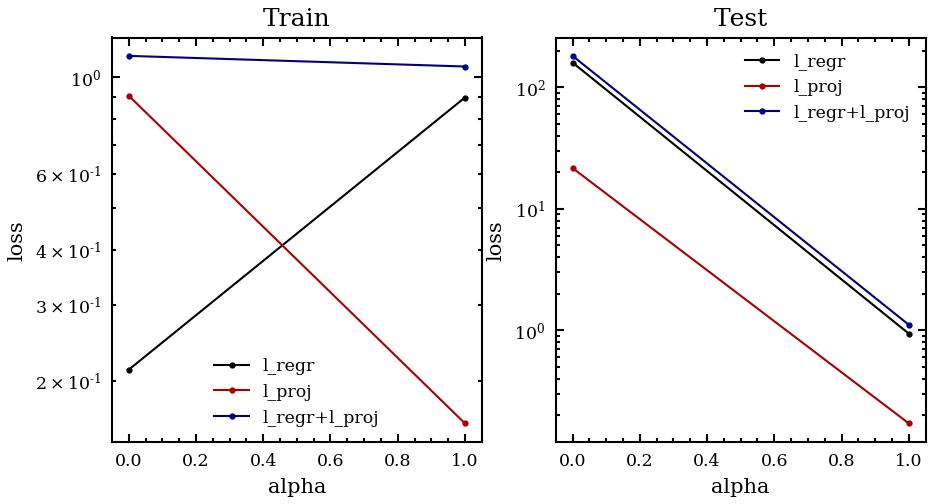

Cutoff: 3.5, Kernel: Linear, 4-Class


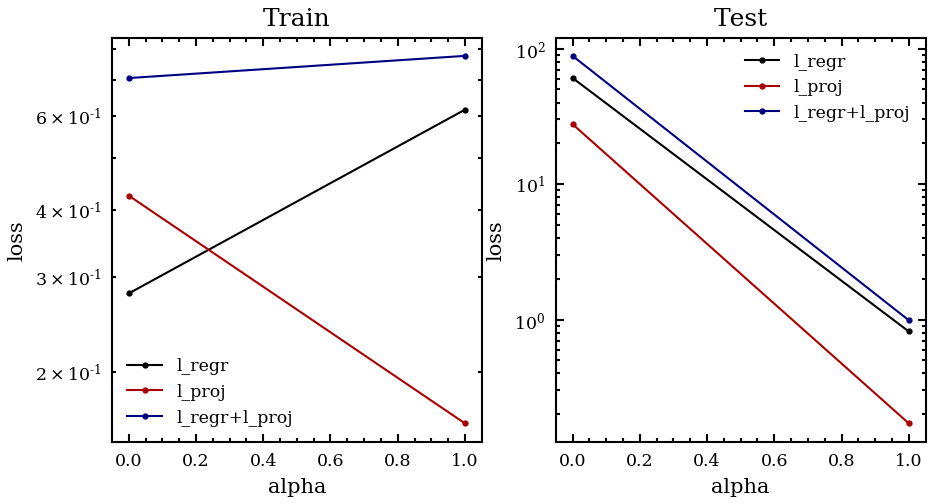

Cutoff: 3.5, Kernel: Gaussian, 2-Class


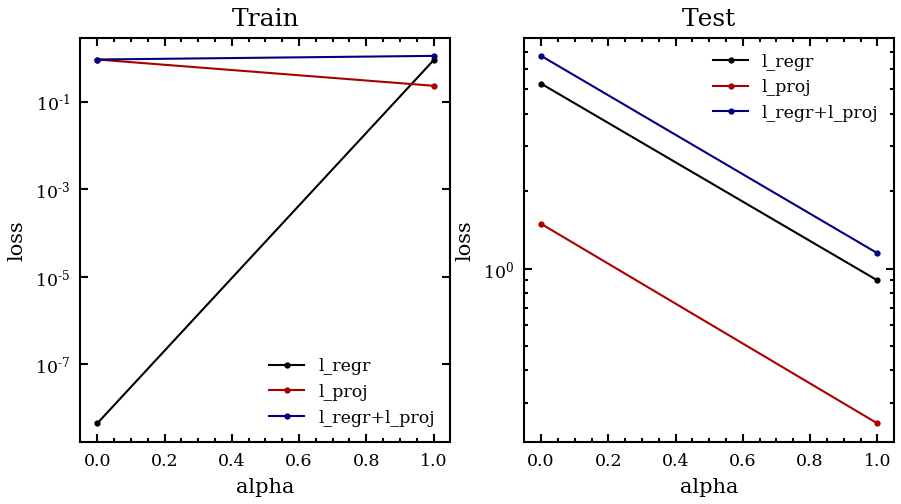

Cutoff: 3.5, Kernel: Gaussian, 4-Class


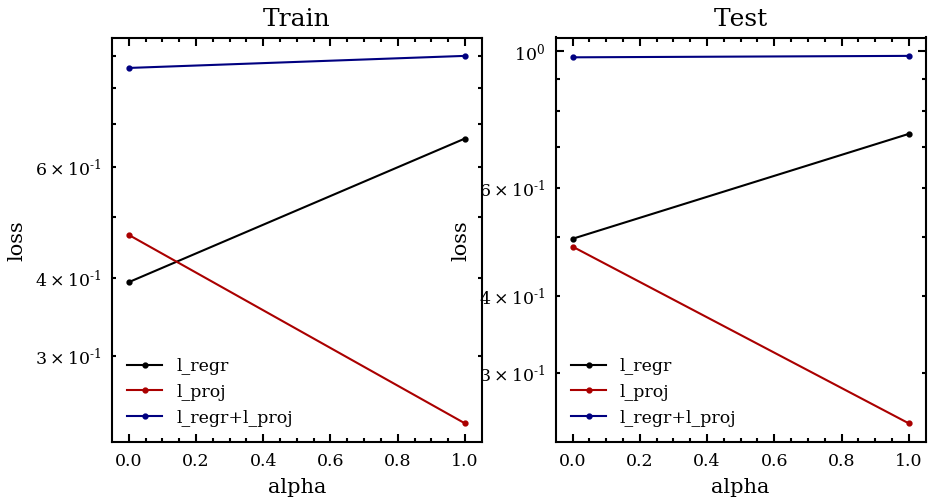

Cutoff: 6.0, Kernel: Linear, 2-Class


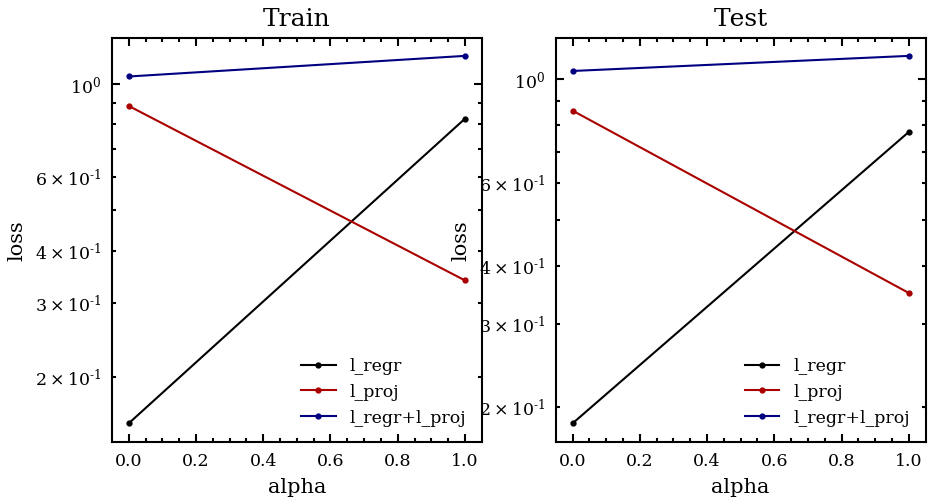

Cutoff: 6.0, Kernel: Linear, 4-Class


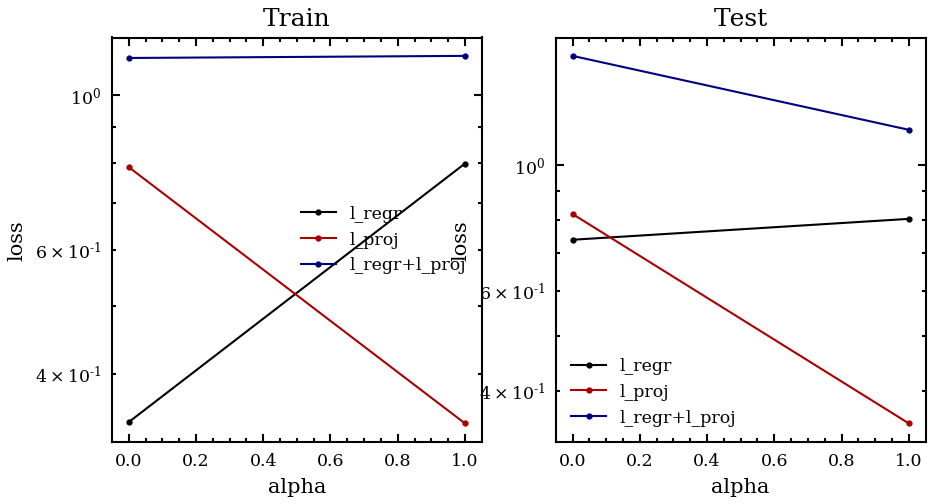

Cutoff: 6.0, Kernel: Gaussian, 2-Class


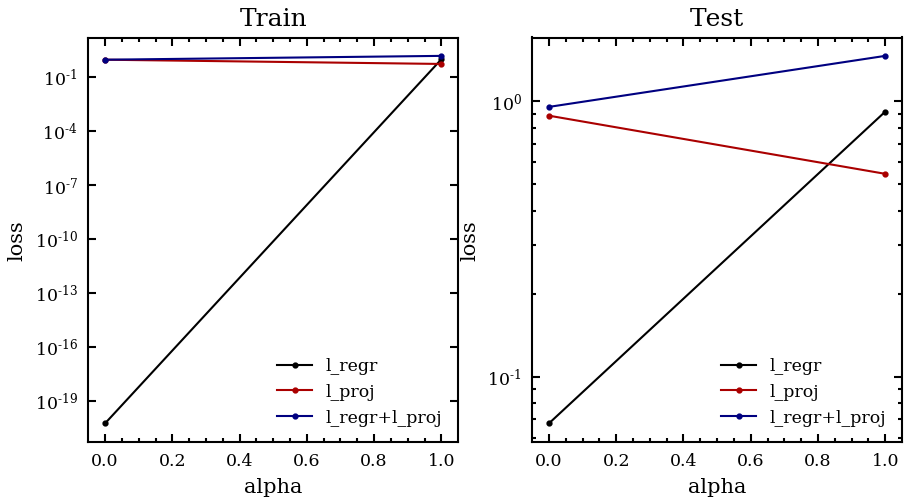

Cutoff: 6.0, Kernel: Gaussian, 4-Class


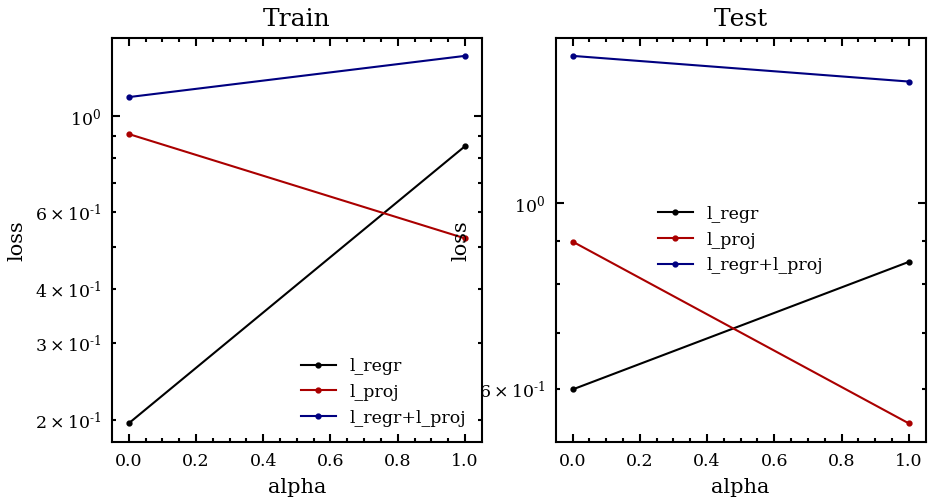

In [48]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        
        work_dir = f'{model_dir}/{cutoff}/Kernel_Models/{kernel_name}/KSVC-KPCovR'

        for n_cantons in (2, 4):
            
            print(f'Cutoff: {cutoff}, Kernel: {kernel_name}, {n_cantons}-Class')
            
            output_dir = f'{n_cantons}-Class'
            
            loss_file = f'{work_dir}/{output_dir}/pcovr_optimization.dat'
            
            # Load losses
            alphas, opt_reg_idx, \
            lr_train_matrix, lr_test_matrix, \
            lp_train_matrix, lp_test_matrix = load_pcovr_losses(loss_file, alphas, regularizations, dt_pcovr)
            
            fig = plt.figure(figsize=(7.0, 3.5))
            axs_loss_sum_train = fig.add_subplot(1, 2, 1)
            axs_loss_sum_test = fig.add_subplot(1, 2, 2)

            # Sum of projection and regression loss over all cantons for the train set
            axs_loss_sum_train.semilogy(alphas, lr_train_matrix[:, opt_reg_idx], 'o-', label='l_regr')
            axs_loss_sum_train.semilogy(alphas, lp_train_matrix[:, opt_reg_idx], 'o-', label='l_proj')
            axs_loss_sum_train.semilogy(alphas, lr_train_matrix[:, opt_reg_idx]+lp_train_matrix[:, opt_reg_idx], 
                                        'o-', label='l_regr+l_proj')

            axs_loss_sum_train.legend()
            axs_loss_sum_train.set_title('Train')
            axs_loss_sum_train.set_xlabel('alpha')
            axs_loss_sum_train.set_ylabel('loss')

            # Sum of projection and regression loss over all cantons for the test set
            axs_loss_sum_test.semilogy(alphas, lr_test_matrix[:, opt_reg_idx], 'o-', label='l_regr')
            axs_loss_sum_test.semilogy(alphas, lp_test_matrix[:, opt_reg_idx], 'o-', label='l_proj')
            axs_loss_sum_test.semilogy(alphas, lr_test_matrix[:, opt_reg_idx]+lp_test_matrix[:, opt_reg_idx],
                                       'o-', label='l_regr+l_proj')

            axs_loss_sum_test.legend()
            axs_loss_sum_test.set_title('Test')
            axs_loss_sum_test.set_xlabel('alpha')
            axs_loss_sum_test.set_ylabel('loss')

            plt.show()

# Linear

In [25]:
# Linear model setup
n_species = 2
group_names = {'power': ['OO', 'OSi', 'SiSi', 
                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
                         'OO+OSi+SiSi'], 
               'radial': ['O', 'Si', 'O+Si']}

In [26]:
deem_name = 'DEEM_10k'
iza_name = 'IZA_226'
deem_dir = f'../Processed_Data/{deem_name}/Data'
iza_dir = f'../Processed_Data/{iza_name}/Data'

## Optimize LinearSVC parameters

In [88]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    work_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
    
    for spectrum_type in tqdm(('power', 'radial'), desc='Spectrum', leave=False):
        spectrum_name = spectrum_type.capitalize()
        
        # Load SOAPs
        deem_file = f'{deem_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        iza_file = f'{iza_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        
        soaps_train, soaps_test = utils.load_soaps(deem_file, iza_file,
                                                   idxs_deem_train, idxs_deem_test,
                                                   idxs_iza_train, idxs_iza_test,
                                                   idxs_iza_delete=[RWY],
                                                   train_test_concatenate=True)
        
        # Scale the SOAPs so they are of a 'usable' magnitude for the SVC
        #soaps_train, soaps_test = utils.preprocess_soaps(soaps_train, soaps_test)
        
        n_features = soaps_train.shape[1]
        feature_groups = extract_species_pair_groups(n_features, n_species, 
                                                     spectrum_type=spectrum_type,
                                                     combinations=True)
        
        for species_pairing, feature_idxs in zip(tqdm(group_names[spectrum_type], 
                                                      desc='Species', leave=False),
                                                 feature_groups):
                        
            for n_cantons in tqdm((2, 4), desc='Classes', leave=False):

                # Prepare outputs
                output_dir = f'{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                
                if not os.path.exists(f'{work_dir}/{output_dir}'):
                    os.makedirs(f'{work_dir}/{output_dir}')
                
                svc_parameter_file = f'{work_dir}/{output_dir}/svc_parameters.json'
                svc_parameters = svc_kwargs['linear'].copy()
                
                svc_errors = []

                for cdx, c in enumerate(tqdm(C, desc='C', leave=False)):
                    svc_parameters.update(C=c)

                    for n in tqdm(range(0, n_subsets), desc='n', leave=False):
                        
                        # Slice SOAPs
                        idxs_train = idxs_train_kernel[n]
                        idxs_test = idxs_test_kernel[n]

                        x_train = soaps_train[idxs_train, :][:, feature_idxs]
                        x_test = soaps_test[idxs_test, :][:, feature_idxs]
                        
                        # Scale the SOAPs so they are of a 'usable' magnitude for the SVC
                        x_train, x_test = utils.preprocess_soaps(x_train, x_test)

                        y_train = cantons_train[n_cantons][idxs_train]
                        y_test = cantons_test[n_cantons][idxs_test]

                        # Run LSVC
                        yp_train, yp_test = \
                            utils.do_svc(x_train, x_test, y_train, y_test, 
                                         svc_type='linear', **svc_parameters, 
                                         outputs=['predictions'])

                        class_accuracy_train[n] = accuracy_score(y_train, yp_train)
                        class_accuracy_test[n] = accuracy_score(y_test, yp_test)
                    
                    model = np.array([(c, class_accuracy_train, class_accuracy_test)], dtype=dt_svm)
                    svc_errors.append(model)
            
                svc_errors = np.concatenate(svc_errors)

                # Stack the arrays in a writable form so we can save in plain text instead of npy/npz
                save_structured_array(f'{work_dir}/{output_dir}/svm_optimization.dat',
                                      svc_errors, dt_svm)

                # TODO: use accuracy only on IZA structures?
                class_accuracy_train_avg = np.mean(svc_errors['class_accuracy_train'], axis=1)
                class_accuracy_test_avg = np.mean(svc_errors['class_accuracy_test'], axis=1)

                # Save LSVC parameters
                idx_C = np.argmax(class_accuracy_test_avg)
                C_opt = svc_errors['C'][idx_C]
                svc_parameters.update(C=C_opt)
                save_json(svc_parameters, svc_parameter_file)   

## Optimal LinearSVC

In [89]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    work_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    for spectrum_type in tqdm(('power', 'radial'), desc='Spectrum', leave=False):
        spectrum_name = spectrum_type.capitalize()
        
        # Load SOAPs
        deem_file = f'{deem_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        iza_file = f'{iza_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        
        soaps_train, soaps_test = utils.load_soaps(deem_file, iza_file,
                                                   idxs_deem_train, idxs_deem_test,
                                                   idxs_iza_train, idxs_iza_test,
                                                   idxs_iza_delete=[RWY],
                                                   train_test_concatenate=True)
        
        # Scale the SOAPs so they are of a 'usable' magnitude for the SVC
        # TODO: does this need to be done separately for each feature chunk?
        #soaps_train, soaps_test = utils.preprocess_soaps(soaps_train, soaps_test)
        
        n_features = soaps_train.shape[1]
        feature_groups = extract_species_pair_groups(n_features, n_species, 
                                                     spectrum_type=spectrum_type,
                                                     combinations=True)
        
        for species_pairing, feature_idxs in zip(tqdm(group_names[spectrum_type], 
                                                      desc='Species', leave=False),
                                                 feature_groups):
            
            x_train_all = soaps_train[:, feature_idxs]
            x_test_all = soaps_test[:, feature_idxs]
            
            x_train = x_train_all[idxs_train_all, :]
            x_test = x_test_all[idxs_test_all, :]

            # Scale the SOAPs so they are of a 'usable' magnitude for the SVC
            x_train, x_test = utils.preprocess_soaps(x_train, x_test)
            
            for n_cantons in tqdm((2, 4), desc='Classes', leave=False):

                # Prepare outputs
                output_dir = f'{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                svc_parameter_file = f'{work_dir}/{output_dir}/svc_parameters.json'

                svc_df_train_file = f'{work_dir}/{output_dir}/svc_structure_dfs_train_optimization.dat'
                svc_df_test_file = f'{work_dir}/{output_dir}/svc_structure_dfs_test_optimization.dat'

                # Assemble properties
                y_train = cantons_train[n_cantons][idxs_train_all]
                y_test = cantons_test[n_cantons][idxs_test_all]

                # LSVC
                svc_parameters = load_json(svc_parameter_file)
                df_train, [df_test, df_train_all, df_test_all] = \
                    utils.do_svc(x_train, [x_test, x_train_all, x_test_all], 
                                 y_train, y_test, svc_type='linear',
                                 **svc_parameters, outputs=['decision_functions'])

                # Save decision functions for LR test and PCovR optimization
                np.savetxt(svc_df_train_file, df_train_all)
                np.savetxt(svc_df_test_file, df_test_all)

## LR check

In [94]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    work_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    for spectrum_type in tqdm(('power', 'radial'), desc='Spectrum', leave=False):
        spectrum_name = spectrum_type.capitalize()
        
        # Load SOAPs
        deem_file = f'{deem_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        iza_file = f'{iza_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'

        soaps_train, soaps_test = utils.load_soaps(deem_file, iza_file,
                                                   idxs_deem_train, idxs_deem_test,
                                                   idxs_iza_train, idxs_iza_test,
                                                   idxs_iza_delete=[RWY],
                                                   train_test_concatenate=True)
        
        n_features = soaps_train.shape[1]
        feature_groups = extract_species_pair_groups(n_features, n_species, 
                                                     spectrum_type=spectrum_type,
                                                     combinations=True)
        
        for species_pairing, feature_idxs in zip(tqdm(group_names[spectrum_type], 
                                                      desc='Species', leave=False),
                                                 feature_groups):
            
            x_train = soaps_train[idxs_train_all, :][:, feature_idxs]
            x_test = soaps_test[idxs_test_all, :][:, feature_idxs]

            # Preprocess the SOAPs like the decision functions
            # (i.e., center and scale) for the regression.
            x_train, x_test, x_center, x_scale = \
                utils.preprocess_data(x_train, x_test)
                        
            for n_cantons in tqdm((2, 4), desc='Classes', leave=False):
            
                # Load decision functions
                input_dir = f'{n_cantons}-Class/{spectrum_name}/{species_pairing}'

                # Files to store IZA and DEEM KSVC decision functions
                svc_df_train_file = f'{work_dir}/{input_dir}/svc_structure_dfs_train_optimization.dat'
                svc_df_test_file = f'{work_dir}/{input_dir}/svc_structure_dfs_test_optimization.dat'

                df_train = np.loadtxt(svc_df_train_file)[idxs_train_all]
                df_test = np.loadtxt(svc_df_test_file)[idxs_test_all]

                # Center and scale the decision functions
                df_train, df_test, df_center, df_scale = \
                    utils.preprocess_data(df_train, df_test)

                # Check that LR can reproduce the decision functions
                dfp_train, dfp_test = \
                utils.regression_check(x_train, x_test, df_train, df_test, 
                                       regression_type='linear')
            
                print(MAE(dfp_train, df_train))
                print(MAE(dfp_test, df_test))

2.27767865148874e-06
0.00012469923787005686
[3.18183754e-07 2.33736227e-07 8.39448794e-07 1.48346101e-06]
[9.68376745e-06 7.90959264e-06 9.41153614e-05 8.08361532e-05]


1.4244638603463199e-06
8.932092269460559e-06
[3.26805301e-07 7.03733042e-07 5.62125613e-07 7.23500446e-07]
[6.71255441e-06 7.30494271e-06 8.24241406e-06 4.69315240e-06]


1.549232749623308e-06
3.51603040276633e-06
[4.11055996e-07 3.42347710e-07 1.68815321e-06 1.05097408e-06]
[6.79299134e-07 5.60427928e-07 3.40668032e-06 2.39518934e-06]


2.4783906346217573e-06
0.00012572341285287464
[6.42205408e-07 8.57836511e-07 9.55583438e-07 1.29709753e-06]
[4.01911576e-05 2.43073831e-05 5.98061957e-05 6.04972775e-05]


1.2436628290576035e-06
5.0729850115831485e-05
[3.56137723e-07 6.23552388e-07 9.51078676e-07 6.12184304e-07]
[1.26344976e-05 1.30809215e-05 3.52722592e-05 2.35079773e-05]


3.3220263116313224e-06
3.64206651158447e-05
[5.58163239e-07 1.50396540e-06 1.14296308e-06 1.66828612e-06]
[4.34258906e-06 1.52769841e-05 1.51253184e-05 1.73855517e-05]


2.3946316272289623e-06
0.00012506228852162413
[5.77525382e-07 8.34973365e-07 1.65293537e-06 1.33630675e-06]
[1.07675578e-05 2.78051068e-05 3.77760023e-05 6.47400046e-05]


1.22038886833233e-11
1.2886494420319305e-11
[1.39373256e-12 5.59126294e-12 6.36300327e-12 5.81546236e-12]
[1.44759922e-12 5.87725801e-12 6.58165301e-12 6.08129981e-12]


6.049092355597596e-09
6.313932293490357e-09
[2.98830499e-09 3.00409613e-09 2.98562909e-09 3.02248583e-09]
[3.11696428e-09 3.13557177e-09 3.11541858e-09 3.15438865e-09]


7.564339510021313e-09
7.95327788913684e-09
[1.19895894e-09 4.60855292e-10 1.20105524e-09 3.78351001e-09]
[1.26118553e-09 4.85562466e-10 1.26363549e-09 3.97939507e-09]


5.917688362344879e-07
4.006461623050655e-06
[2.62528460e-07 1.28237800e-07 1.62976683e-07 3.07430286e-07]
[6.81289031e-07 6.05213544e-07 5.27136927e-07 2.06682302e-06]


1.807190091945555e-06
3.2656938272455685e-06
[6.81305014e-07 6.35796260e-07 1.20381051e-06 8.77595531e-07]
[1.36972403e-06 1.21541185e-06 2.34942366e-06 1.58183897e-06]


1.209773090238635e-06
1.5339182975629066e-06
[4.59992804e-07 6.41900056e-07 4.66413128e-07 5.87583469e-07]
[5.90384680e-07 8.15165631e-07 5.80670518e-07 7.42064100e-07]


1.971843501371804e-06
7.042838770812252e-06
[1.07033161e-06 6.45439307e-07 1.23464308e-06 9.86868038e-07]
[4.08963245e-06 3.57388702e-06 6.38061006e-06 3.51038792e-06]


1.1494261845712526e-06
5.285509537898858e-06
[4.93725620e-07 2.60771612e-07 6.78614920e-07 5.82743839e-07]
[1.34739863e-06 1.43980870e-06 1.50563331e-06 2.62051471e-06]


2.797790751141253e-06
7.527979590653751e-06
[1.81791444e-06 1.21810956e-06 1.27815697e-06 1.34458142e-06]
[3.83061478e-06 2.85335293e-06 3.18084621e-06 3.62428347e-06]


2.5941714911607005e-06
1.0571263008341437e-05
[1.51259530e-06 8.20194817e-07 1.83201771e-06 1.27945722e-06]
[7.67240312e-06 5.16450917e-06 7.05753225e-06 5.22832350e-06]


9.171700649548409e-14
1.017188110376947e-13
[9.48082911e-13 3.80768590e-14 1.07868066e-12 2.12290928e-13]
[9.57081644e-13 3.88479231e-14 1.08636147e-12 2.18295388e-13]


1.7772749689976221e-10
1.8299752463793837e-10
[2.06631562e-11 8.32296478e-11 1.10015098e-10 8.60971153e-11]
[2.12722417e-11 8.56888531e-11 1.13177806e-10 8.86560974e-11]


6.345371435386674e-11
6.367259582017275e-11
[4.75228855e-11 1.38726275e-11 5.70477221e-11 3.72617252e-11]
[4.76700842e-11 1.39351583e-11 5.73464436e-11 3.74009549e-11]



## Optimize PCovR parameters

In [28]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    work_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    for spectrum_type in tqdm(('power', 'radial'), desc='Spectrum', leave=False):
        spectrum_name = spectrum_type.capitalize()
        
        # Load SOAPs
        deem_file = f'{deem_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        iza_file = f'{iza_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        
        soaps_train, soaps_test = utils.load_soaps(deem_file, iza_file,
                                                   idxs_deem_train, idxs_deem_test,
                                                   idxs_iza_train, idxs_iza_test,
                                                   idxs_iza_delete=[RWY],
                                                   train_test_concatenate=True)
        
        # Scale the SOAPs so they are of a 'usable' magnitude for the SVC
        #soaps_train, soaps_test = utils.preprocess_soaps(soaps_train, soaps_test)
        
        n_features = soaps_train.shape[1]
        feature_groups = extract_species_pair_groups(n_features, n_species, 
                                                     spectrum_type=spectrum_type,
                                                     combinations=True)
        
        for species_pairing, feature_idxs in zip(tqdm(group_names[spectrum_type], 
                                                      desc='Species', leave=False),
                                                 feature_groups):
                        
            for n_cantons in tqdm((2, 4), desc='Classes', leave=False):
                
                # Prepare inputs and outputs
                output_dir = f'{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                pcovr_parameter_file = f'{work_dir}/{output_dir}/pcovr_parameters.json'
                svc_parameter_file = f'{work_dir}/{output_dir}/svc_parameters.json'
                
                svc_parameters = load_json(svc_parameter_file)
                pcovr_parameters = pcovr_kwargs['linear'].copy()

                # Load decision functions
                svc_df_train_file = f'{work_dir}/{output_dir}/svc_structure_dfs_train_optimization.dat'
                svc_df_test_file = f'{work_dir}/{output_dir}/svc_structure_dfs_test_optimization.dat'

                df_train = np.loadtxt(svc_df_train_file)
                df_test = np.loadtxt(svc_df_test_file)
                
                pcovr_errors = []

                for adx, a in enumerate(tqdm(alphas, desc='Alpha', leave=False)):
                    for rdx, r in enumerate(tqdm(regularizations, desc='Reg', leave=False)):
                        
                        pcovr_parameters.update(alpha=a, regularization=r)

                        # Initialize matrices of losses
                        lr_train = np.zeros(n_subsets)
                        lp_train = np.zeros(n_subsets)
                        lr_test = np.zeros(n_subsets)
                        lp_test = np.zeros(n_subsets)

                        for n in tqdm(range(0, n_subsets), desc='n', leave=False):

                            # Slice the SOAPs
                            idxs_train = idxs_train_kernel[n]
                            idxs_test = idxs_test_kernel[n]

                            x_train = soaps_train[idxs_train, :][:, feature_idxs]
                            x_test = soaps_test[idxs_test, :][:, feature_idxs]

                            # Scale the SOAPs so they are of a 'usable' magnitude for the SVC
                            x_train, x_test, x_center, x_scale = \
                                utils.preprocess_data(x_train, x_test)

                            y_train = df_train[idxs_train]
                            y_test = df_test[idxs_test]

                            # Assemble properties
                            y_train, y_test, y_center, y_scale = \
                                utils.preprocess_data(y_train, y_test)

                            # Run PCovR
                            t_train, t_test, yp_train, yp_test, xr_train, xr_test = \
                                utils.do_pcovr(x_train, x_test, y_train, y_test, 
                                               pcovr_type='linear', compute_xr=True,
                                               **pcovr_parameters)

                            # Post process the PCovR decision functions
                            # (i.e., turn them back into canton predictions)
                            predicted_cantons_train, predicted_cantons_test = \
                                utils.postprocess_decision_functions(yp_train, yp_test, y_center, y_scale,
                                                                     df_type=svc_parameters['multi_class'],
                                                                     n_classes=n_cantons)

                            # Collect regression and projection (PCovR) losses for each canton
                            # TODO: losses on just IZA?
                            lr_train[n], lr_test[n] = \
                                compute_regression_losses(y_train, y_test, yp_train, yp_test)

                            lp_train[n], lp_test[n] = \
                                compute_linear_projection_losses(x_train, x_test,
                                                                 xr_train, xr_test)

                        # Collect errors
                        model = np.array([(a, r, lr_train, lr_test, lp_train, lp_test)], dtype=dt_pcovr)
                        pcovr_errors.append(model)

                pcovr_errors = np.concatenate(pcovr_errors)

                save_structured_array(f'{work_dir}/{output_dir}/pcovr_optimization.dat', 
                                      pcovr_errors, dt_pcovr)

                # Extract optimal hyperparameters
                lr_avg_test = np.mean(pcovr_errors['lr_test'], axis=1)
                lp_avg_test = np.mean(pcovr_errors['lp_test'], axis=1)

                idx_opt = np.argmin(lr_avg_test + lp_avg_test)

                opt_alpha = pcovr_errors['alpha'][idx_opt]
                opt_reg = pcovr_errors['regularization'][idx_opt]

                print(opt_alpha, opt_reg)

                # Save KPCovR parameters
                pcovr_parameters.update(alpha=opt_alpha,
                                        regularization=opt_reg)

                save_json(pcovr_parameters, pcovr_parameter_file)

0.0 1e-12


0.0 0.1


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 0.1


0.0 0.1


0.0 0.1


0.0 1e-12


0.0 1e-12


0.0 0.1


0.0 0.1


1.0 1e-12


0.0 0.1


1.0 1e-12


0.0 1e-12


1.0 1e-12


0.0 0.1


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 0.1


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


0.0 1e-12


1.0 1e-12


0.0 0.1


0.0 0.1


0.0 0.1


1.0 1e-12


0.0 0.1



## Check for optimization problems

Cutoff: 3.5, Spectrum: Power, Species: OO, 2-Class


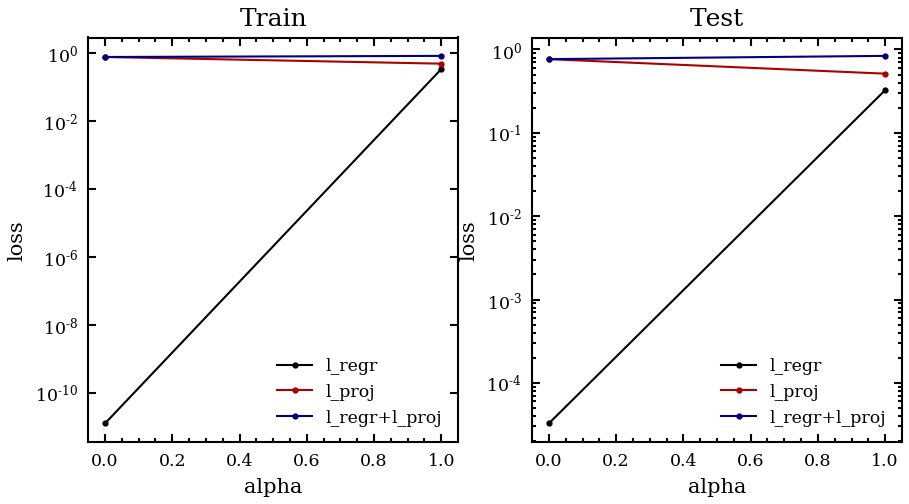

Cutoff: 3.5, Spectrum: Power, Species: OO, 4-Class


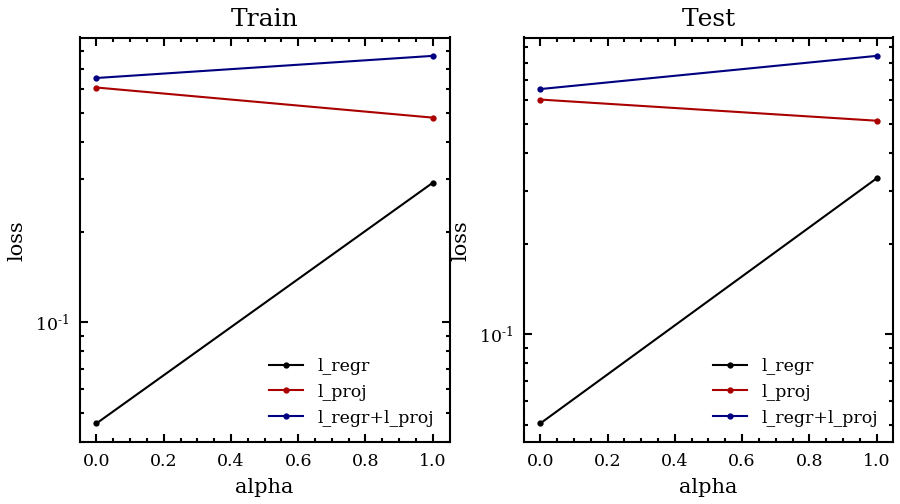

Cutoff: 3.5, Spectrum: Power, Species: OSi, 2-Class


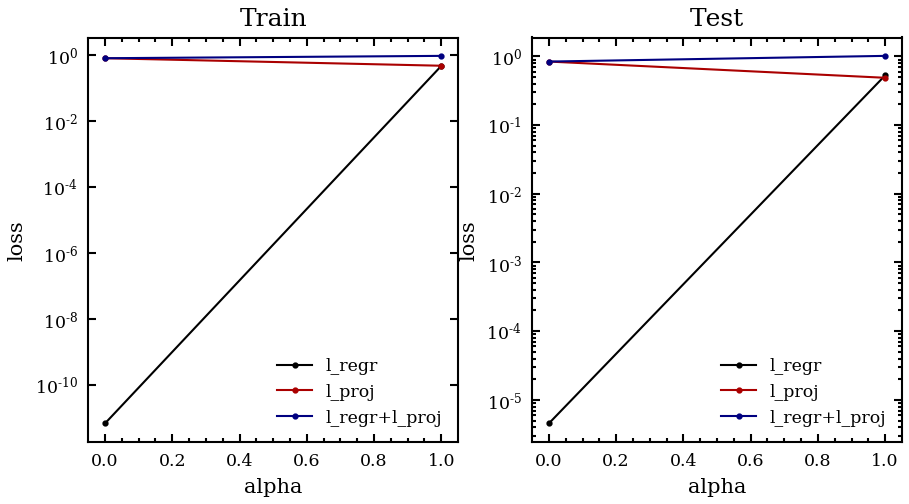

Cutoff: 3.5, Spectrum: Power, Species: OSi, 4-Class


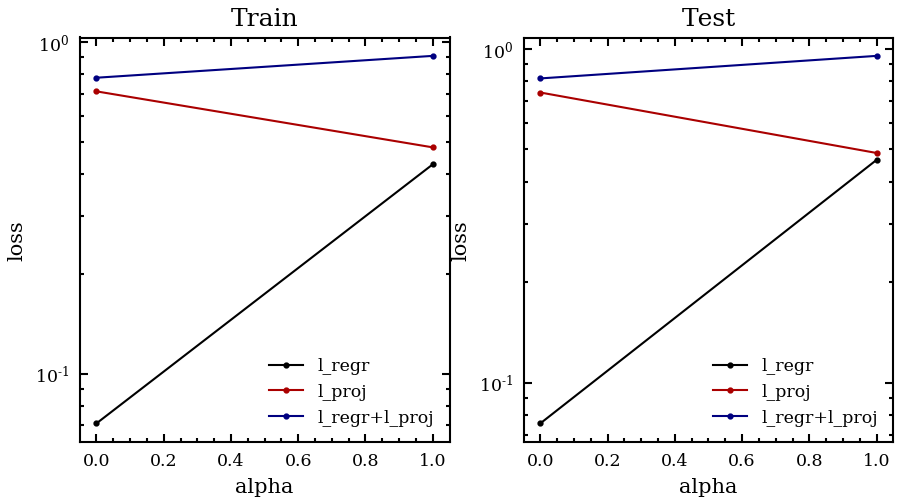

Cutoff: 3.5, Spectrum: Power, Species: SiSi, 2-Class


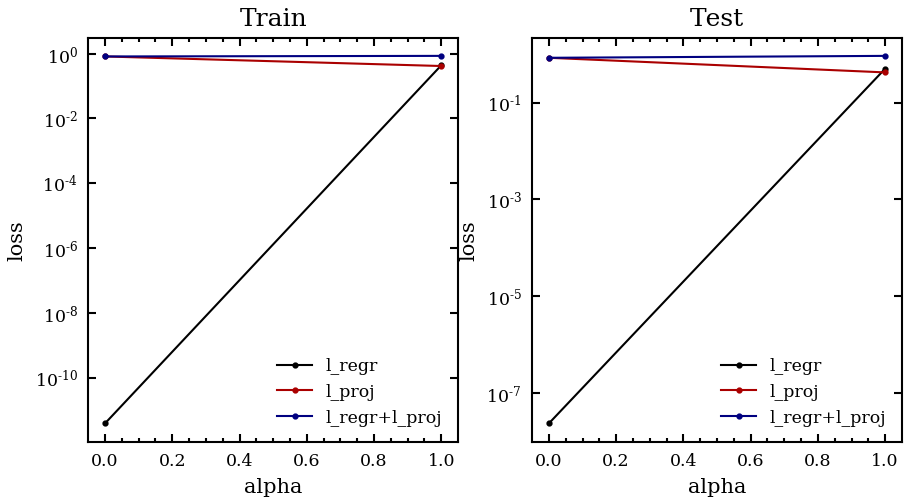

Cutoff: 3.5, Spectrum: Power, Species: SiSi, 4-Class


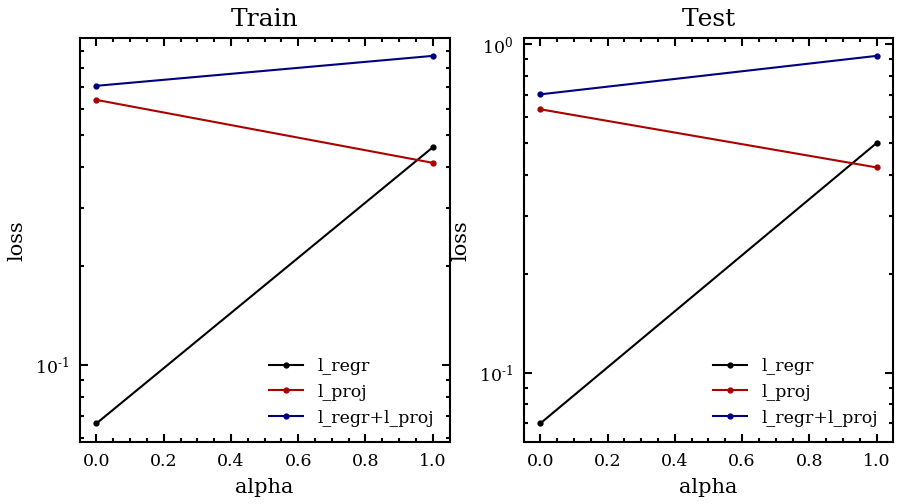

Cutoff: 3.5, Spectrum: Radial, Species: O, 2-Class


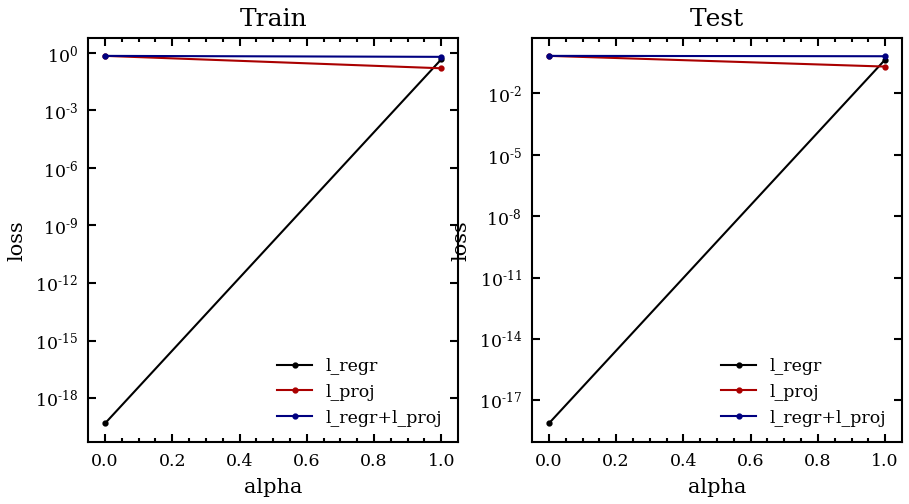

Cutoff: 3.5, Spectrum: Radial, Species: O, 4-Class


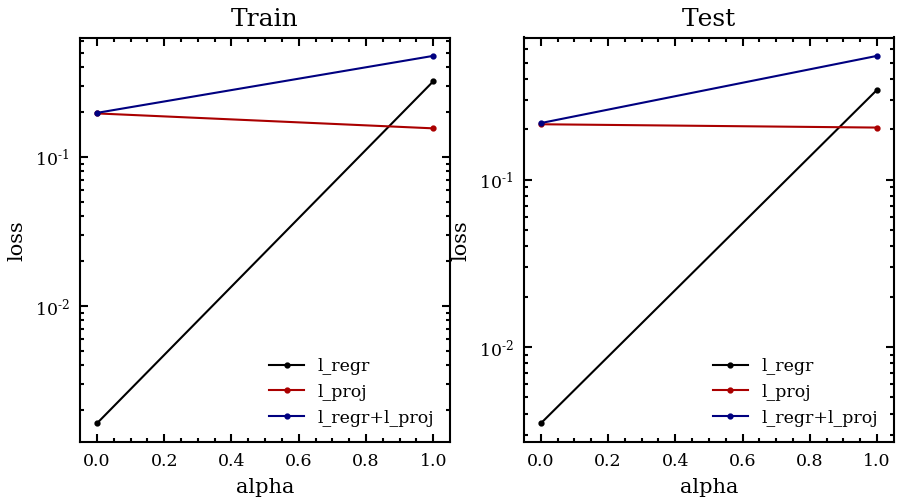

Cutoff: 3.5, Spectrum: Radial, Species: Si, 2-Class


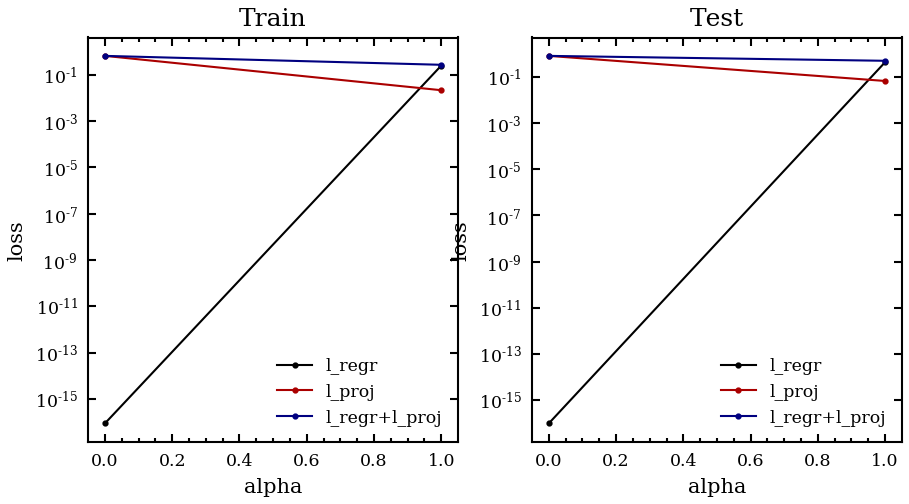

Cutoff: 3.5, Spectrum: Radial, Species: Si, 4-Class


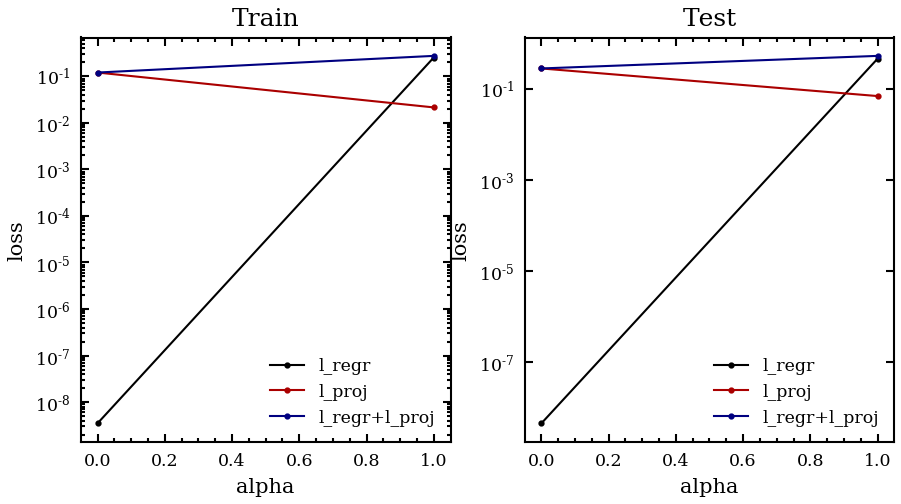

Cutoff: 3.5, Spectrum: Radial, Species: O+Si, 2-Class


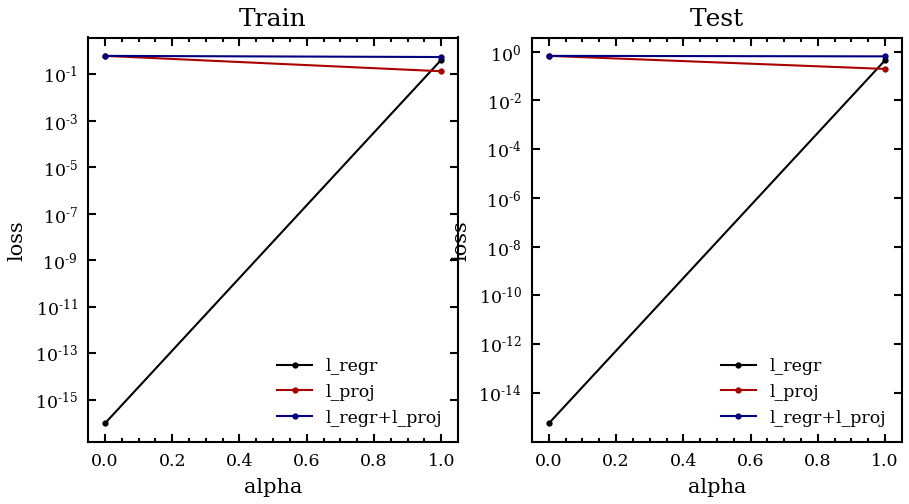

Cutoff: 3.5, Spectrum: Radial, Species: O+Si, 4-Class


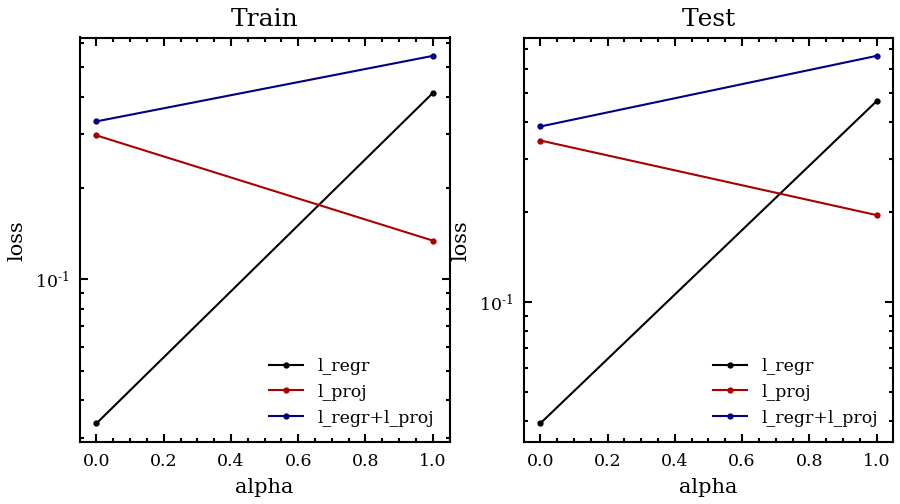

Cutoff: 6.0, Spectrum: Power, Species: OO, 2-Class


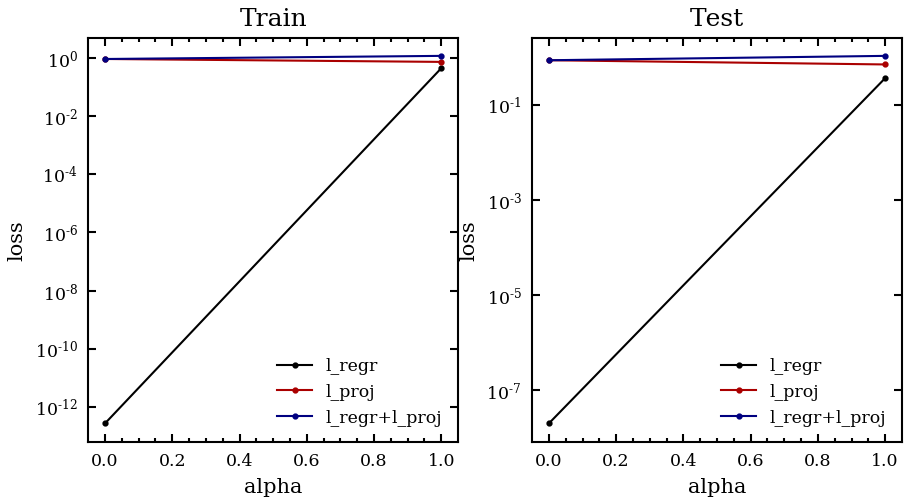

Cutoff: 6.0, Spectrum: Power, Species: OO, 4-Class


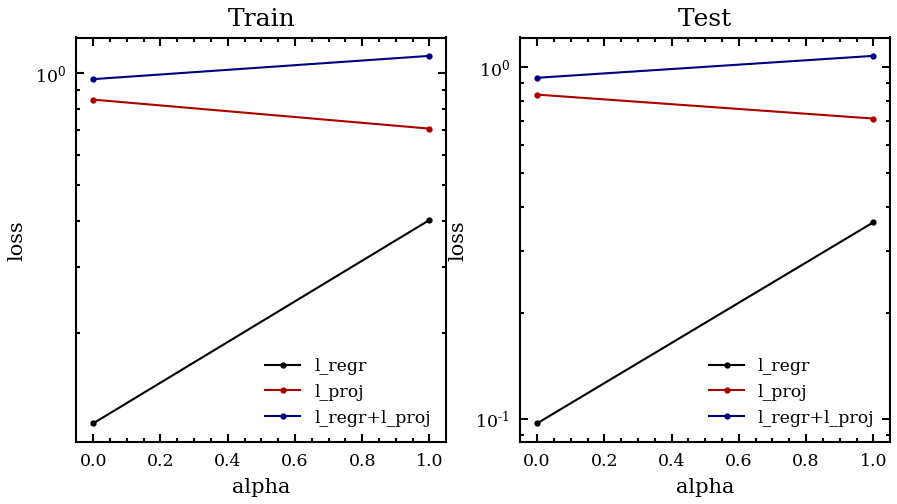

Cutoff: 6.0, Spectrum: Power, Species: OSi, 2-Class


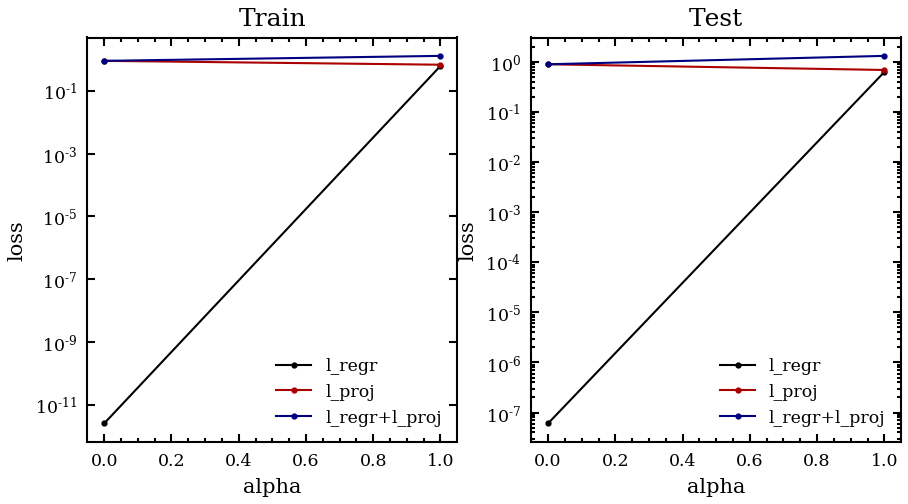

Cutoff: 6.0, Spectrum: Power, Species: OSi, 4-Class


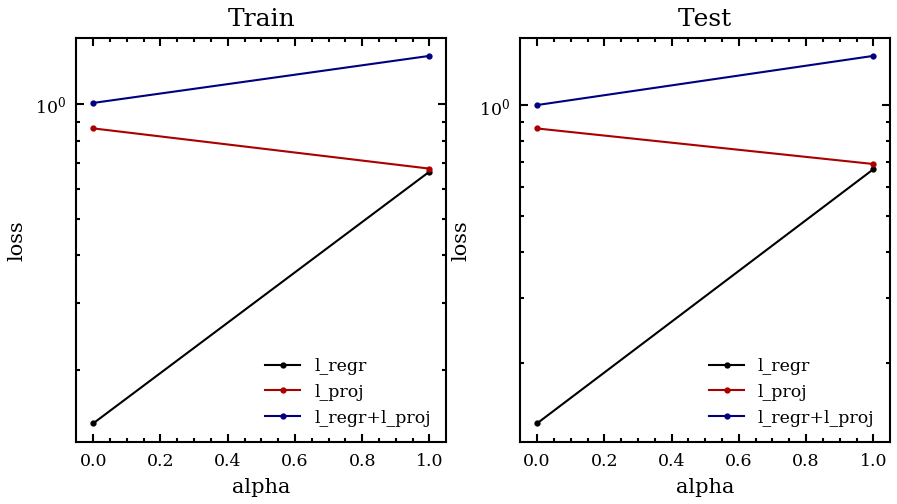

Cutoff: 6.0, Spectrum: Power, Species: SiSi, 2-Class


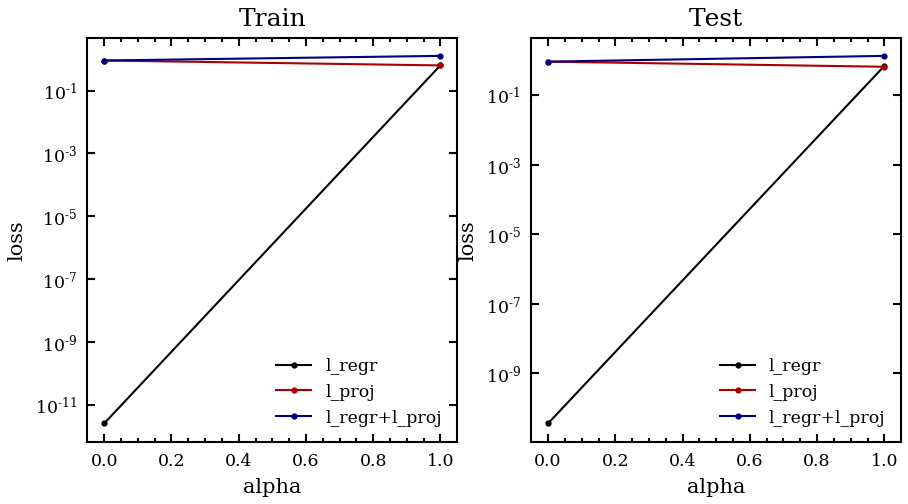

Cutoff: 6.0, Spectrum: Power, Species: SiSi, 4-Class


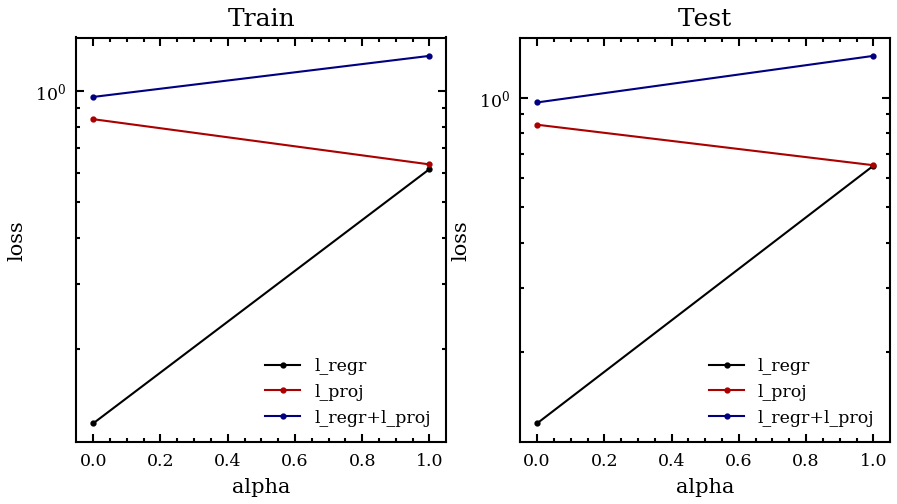

Cutoff: 6.0, Spectrum: Radial, Species: O, 2-Class


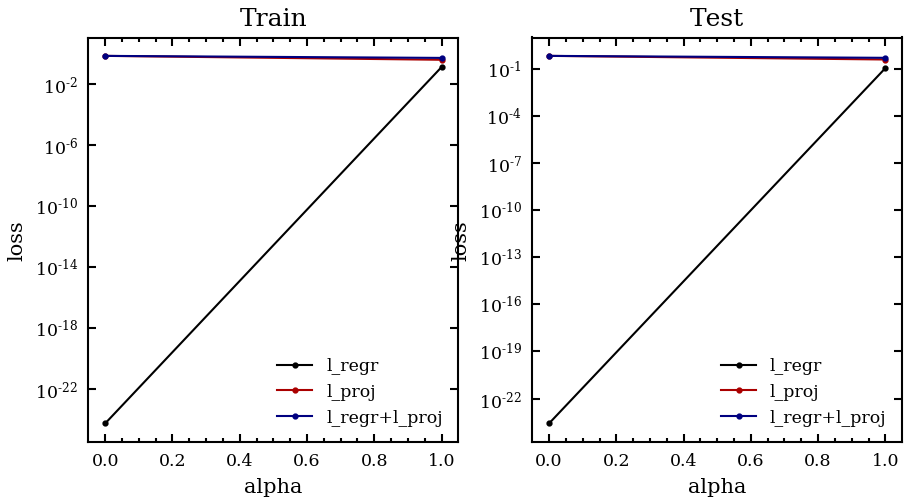

Cutoff: 6.0, Spectrum: Radial, Species: O, 4-Class


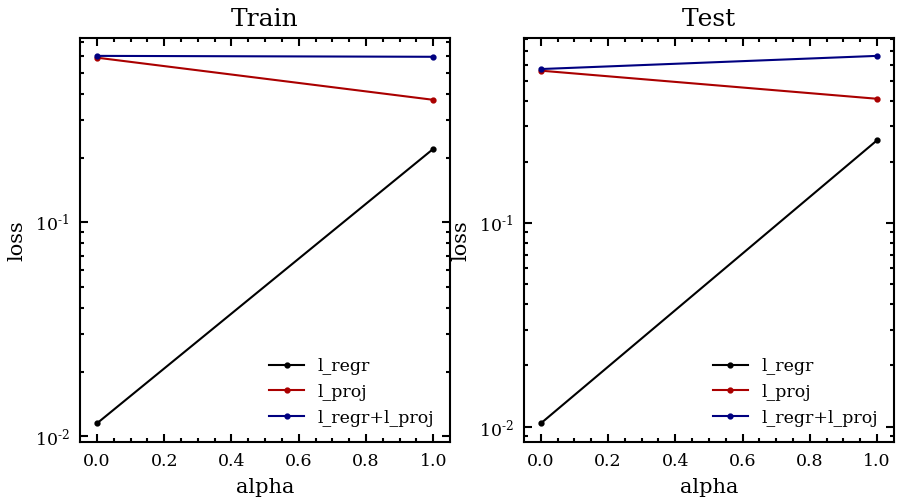

Cutoff: 6.0, Spectrum: Radial, Species: Si, 2-Class


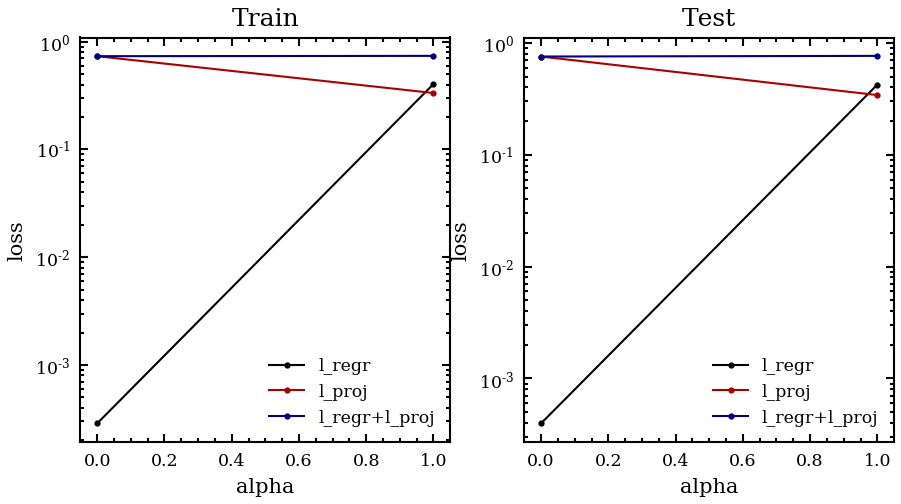

Cutoff: 6.0, Spectrum: Radial, Species: Si, 4-Class


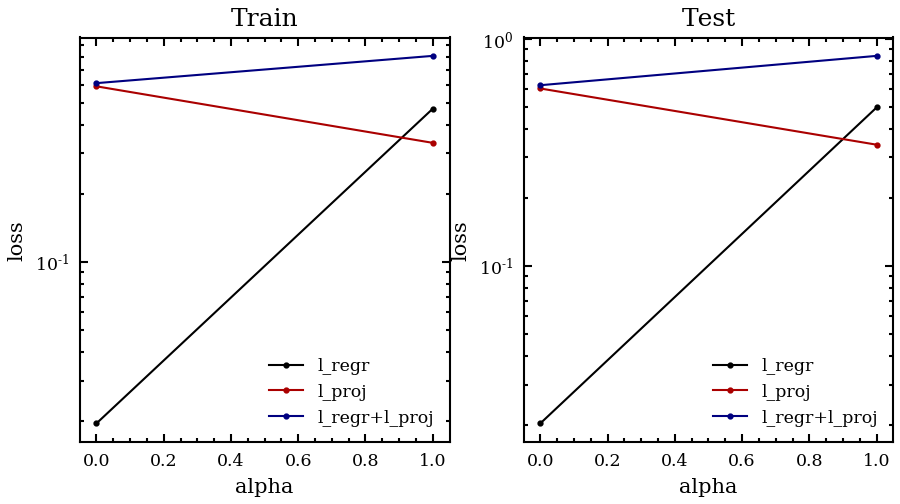

Cutoff: 6.0, Spectrum: Radial, Species: O+Si, 2-Class


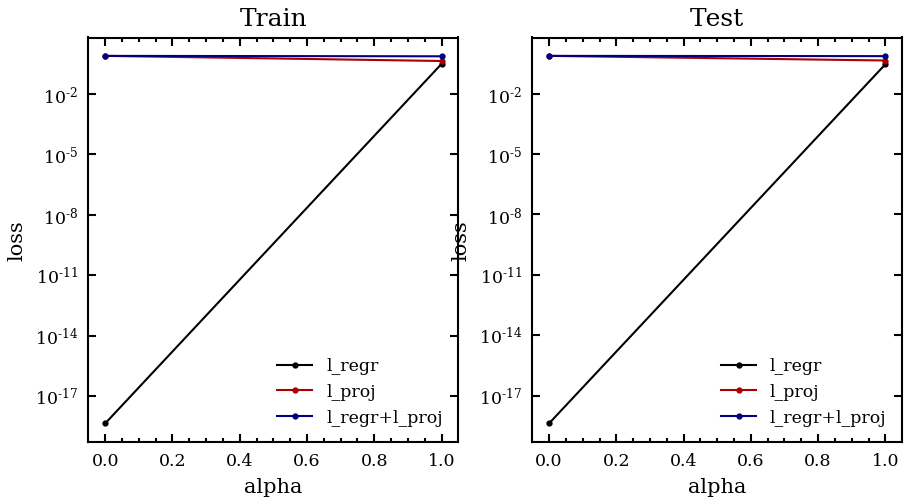

Cutoff: 6.0, Spectrum: Radial, Species: O+Si, 4-Class


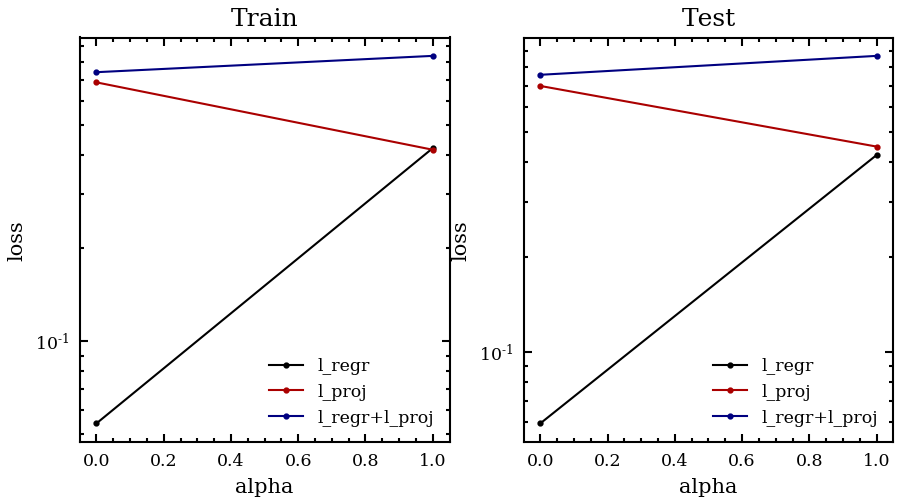

In [29]:
for cutoff in cutoffs:
    work_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing, feature_idxs in zip(group_names[spectrum_type], feature_groups):
                        
            for n_cantons in (2, 4):
                
                print(f'Cutoff: {cutoff}, Spectrum: {spectrum_name}, Species: {species_pairing}, {n_cantons}-Class')
                
                output_dir = f'{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                loss_file = f'{work_dir}/{output_dir}/pcovr_optimization.dat'

                # Load losses
                alphas, opt_reg_idx, \
                lr_train_matrix, lr_test_matrix, \
                lp_train_matrix, lp_test_matrix = load_pcovr_losses(loss_file, alphas, regularizations, dt_pcovr)

                fig = plt.figure(figsize=(7.0, 3.5))
                axs_loss_sum_train = fig.add_subplot(1, 2, 1)
                axs_loss_sum_test = fig.add_subplot(1, 2, 2)

                # Sum of projection and regression loss over all cantons for the train set
                axs_loss_sum_train.semilogy(alphas, lr_train_matrix[:, opt_reg_idx], 'o-', label='l_regr')
                axs_loss_sum_train.semilogy(alphas, lp_train_matrix[:, opt_reg_idx], 'o-', label='l_proj')
                axs_loss_sum_train.semilogy(alphas, lr_train_matrix[:, opt_reg_idx]
                                            + lp_train_matrix[:, opt_reg_idx], 'o-', label='l_regr+l_proj')

                axs_loss_sum_train.legend()
                axs_loss_sum_train.set_title('Train')
                axs_loss_sum_train.set_xlabel('alpha')
                axs_loss_sum_train.set_ylabel('loss')

                # Sum of projection and regression loss over all cantons for the test set
                axs_loss_sum_test.semilogy(alphas, lr_test_matrix[:, opt_reg_idx], 'o-', label='l_regr')
                axs_loss_sum_test.semilogy(alphas, lp_test_matrix[:, opt_reg_idx], 'o-', label='l_proj')
                axs_loss_sum_test.semilogy(alphas, lr_test_matrix[:, opt_reg_idx]
                                           + lp_test_matrix[:, opt_reg_idx], 'o-', label='l_regr+l_proj')

                axs_loss_sum_test.legend()
                axs_loss_sum_test.set_title('Test')
                axs_loss_sum_test.set_xlabel('alpha')
                axs_loss_sum_test.set_ylabel('loss')

                plt.show()

# Logistic Regression